In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import importlib
from pathlib import Path
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from itertools import product
from collections import defaultdict

In [2]:
# 获取项目根目录
project_root = Path(os.getcwd()).parent
sys.path.append(str(project_root))

# 导入数据
processed_path = Path(project_root) / 'data' / 'processed'
learning_data = pd.read_csv(processed_path / 'Task2_processed.csv')

In [3]:
import src.Bayesian_new.problems.model as model
importlib.reload(model)
from src.Bayesian_new.problems.model import SingleRationalModel

import src.Bayesian_new.problems.config as config
importlib.reload(config)
from src.Bayesian_new.problems.config import config_base

#### Fig 1C

In [171]:
import src.nips_plot as nips_plot
importlib.reload(nips_plot)
from src.nips_plot import Fig1_Ntrial

# 初始化处理器
plot_fig1_ntrial = Fig1_Ntrial()

In [187]:
plots_dir = Path(project_root) / 'results' / 'Nips_figures_final'
plot_fig1_ntrial.plot_trial_number(learning_data,iCon=1,
                                figsize=(2, 6.2),
                                color='#A6A6A6',
                                save_path=plots_dir / 'Fig1D_ntrial.svg')

Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/Fig1D_ntrial.svg


#### Fig 1D

In [142]:
import src.nips_plot as nips_plot
importlib.reload(nips_plot)
from src.nips_plot import Fig1_Acc

# 初始化处理器
plot_fig1_acc = Fig1_Acc()

In [191]:
plots_dir = Path(project_root) / 'results' / 'Nips_figures_final'
plot_fig1_acc.plot_accuracy(learning_data,
                            subject_ids=[1,4],
                            subfig=1,
                            nrow=2,
                            window_size=16,
                            block_size=64,
                            h_pad=8.8,
                            color='#A6A6A6',
                            max_trial=192,
                            figsize=(2.3, 5.5),
                            save_path=plots_dir / 'Fig1D_accuracy_1.svg')

Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/Fig1D_accuracy_1.svg


In [188]:
plot_fig1_acc.plot_accuracy(learning_data,
                            subject_ids=[7,10,13,19,22,16],
                            subfig=2,
                            nrow=2,
                            window_size=16,
                            block_size=64,
                            h_pad=8,
                            color=['#595959','#0D0D0D'],
                            sub_text=[3,4,5,6,7,8],
                            figsize=(10.5, 5.5),
                            save_path=plots_dir / 'Fig1D_accuracy_2.svg')

Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/Fig1D_accuracy_2.svg


#### Fig 1E

In [4]:
import src.nips_plot as nips_plot
importlib.reload(nips_plot)
from src.nips_plot import Fig1_Oral

# 初始化处理器
plot_fig1_oral = Fig1_Oral()

##### subject-1

In [72]:
# 导入被试数据
iSub = 7
subject_data = learning_data[learning_data['iSub'] == iSub]
subject_data = subject_data.reset_index(drop=True)
ncats=2

# 绘制单帧图片
plots_dir = Path(project_root) / 'results' / 'Nips_figures' 
plot_fig1_oral.plot_human_trajactory(ncats, subject_data, 1, plots_dir, row_indices=248)

完成：仅绘制行 [248]，图表已保存至 /home/yangjiong/CategoryLearning/results/Nips_figures/choice*/ 文件夹。


In [73]:
iSub = 7
subject_data = learning_data[learning_data['iSub'] == iSub]
subject_data = subject_data.reset_index(drop=True)
ncats=2

plot_fig1_oral.plot_human_trajactory(ncats, subject_data, 2, plots_dir, 112, 248, 248)

完成：仅绘制行 [248]，图表已保存至 /home/yangjiong/CategoryLearning/results/Nips_figures/choice*/ 文件夹。


##### subject-2

In [81]:
# 导入被试数据
iSub = 1
subject_data = learning_data[learning_data['iSub'] == iSub]
subject_data = subject_data.reset_index(drop=True)
ncats=2

# 绘制单帧图片
plots_dir = Path(project_root) / 'results' / 'Nips_figures' 
plot_fig1_oral.plot_human_trajactory(ncats, subject_data, 1, plots_dir, row_indices=127)

完成：仅绘制行 [127]，图表已保存至 /home/yangjiong/CategoryLearning/results/Nips_figures/choice*/ 文件夹。


In [82]:
iSub = 1
subject_data = learning_data[learning_data['iSub'] == iSub]
subject_data = subject_data.reset_index(drop=True)
ncats=2

plot_fig1_oral.plot_human_trajactory(ncats, subject_data, 2, plots_dir, 68, 127, 127)

完成：仅绘制行 [127]，图表已保存至 /home/yangjiong/CategoryLearning/results/Nips_figures/choice*/ 文件夹。


##### model

In [84]:
# 导入模型数据
result_path = Path(project_root) / 'results' / 'Model_results'
fitting_results = joblib.load(result_path / 'M0_base.joblib')

In [86]:
iSub = 7
sub_result = fitting_results[iSub]
step_results = sub_result['best_step_results']
cond = sub_result['condition']

model  = SingleRationalModel(config_base, condition=cond)
model_centers = plot_fig1_oral.get_model_centers(step_results,
                                                 model,
                                                 ncats=ncats)
model_centers['iSub']     = iSub
model_centers['iTrial']   = model_centers.index + 1

In [94]:
# 绘制单帧图片
plots_dir = Path(project_root) / 'results' / 'Nips_figures' 
plot_fig1_oral.plot_model_trajactory(ncats, model_centers, 1, plots_dir, row_indices=29)

完成模型轨迹绘制：行 [29]，图表已保存至 /home/yangjiong/CategoryLearning/results/Nips_figures/choice*/ 文件夹。


In [89]:
plot_fig1_oral.plot_model_trajactory(ncats, model_centers, 2, plots_dir, 30, 30, 29)

完成模型轨迹绘制：行 [29]，图表已保存至 /home/yangjiong/CategoryLearning/results/Nips_figures/choice*/ 文件夹。


#### Fig 3B

In [192]:
# 加载拟合结果
base_results = joblib.load(Path(project_root) / 'results' / 'Bayesian_new' / 'M_Base_fitting_results.joblib')
forget_results = joblib.load(Path(project_root) / 'results' / 'Bayesian_new' / 'M_Fgt_fitting_results_400.joblib')
cluster_results = joblib.load(Path(project_root) / 'results' / 'Bayesian_recon' / 'M_cl_max7_randp_k1_acc7.joblib')
fgtcluster_results = joblib.load(Path(project_root) / 'results' / 'Bayesian_recon' / 'M_fgt_cl.joblib')
fgtclusterper_results = joblib.load(Path(project_root) / 'results' / 'Bayesian_recon' / 'M_fgt_cl_per.joblib')

In [193]:
def get_prediction(fitting_results, learning_data):
    predict_results = {}

    for i, (iSub, subject_data) in enumerate(learning_data.groupby('iSub')):
        condition = subject_data['condition'].iloc[0]
        model_base = SingleRationalModel(config_base, condition=condition)
        s_data = (subject_data[["feature1", "feature2", "feature3", "feature4"]].values,
                subject_data["choice"].values,
                subject_data["feedback"].values, 
                subject_data["category"].values)
        
        step_results = fitting_results[iSub].get('step_results', fitting_results[iSub].get('best_step_results'))
        results = model_base.predict_choice(s_data, step_results, use_cached_dist=False, window_size=16)

        predict_results[iSub] = {
            'condition': condition,
            'true_acc': results['true_acc'],
            'pred_acc': results['pred_acc'],
            'sliding_true_acc': results['sliding_true_acc'],
            'sliding_pred_acc': results['sliding_pred_acc'],
            'sliding_pred_acc_std': results['sliding_pred_acc_std']
        }
    return predict_results

In [194]:
# base_predict_results = get_prediction(base_results, learning_data)
# forget_predict_results = get_prediction(forget_results, learning_data)
# cluster_predict_results = get_prediction(cluster_results, learning_data)
# fgtcluster_predict_results = get_prediction(fgtcluster_results, learning_data)
fgtclusterper_predict_results = get_prediction(fgtclusterper_results, learning_data)

In [195]:
# joblib.dump(base_predict_results, Path(project_root) / 'results' / 'Bayesian_recon' / 'M_base_prediction.joblib')
# joblib.dump(forget_predict_results, Path(project_root) / 'results' / 'Bayesian_recon' / 'M_fgt_prediction.joblib')
# joblib.dump(cluster_predict_results, Path(project_root) / 'results' / 'Bayesian_recon' / 'M_cluster_prediction.joblib')
# joblib.dump(fgtcluster_predict_results, Path(project_root) / 'results' / 'Bayesian_recon' / 'M_fgt_cluster_prediction.joblib')
joblib.dump(fgtclusterper_predict_results, Path(project_root) / 'results' / 'Bayesian_recon' / 'M_fgt_cluster_per_prediction.joblib')


['/home/yangjiong/CategoryLearning/results/Bayesian_recon/M_fgt_cluster_per_prediction.joblib']

In [ ]:
# 加载结果
base_predict_results = joblib.load(Path(project_root) / 'results' / 'Bayesian_recon' / 'M_base_prediction.joblib')
forget_predict_results = joblib.load(Path(project_root) / 'results' / 'Bayesian_recon' / 'M_fgt_prediction.joblib')
cluster_predict_results = joblib.load(Path(project_root) / 'results' / 'Bayesian_recon' / 'M_cluster_prediction.joblib')
fgtcluster_predict_results = joblib.load(Path(project_root) / 'results' / 'Bayesian_recon' / 'M_fgt_cluster_prediction.joblib')
fgtclusterper_predict_results = joblib.load(Path(project_root) / 'results' / 'Bayesian_recon' / 'M_fgt_cluster_per_prediction.joblib')

In [202]:
import src.nips_plot as nips_plot
importlib.reload(nips_plot)
from src.nips_plot import Fig3_Group

# 初始化处理器
plot_fig3 = Fig3_Group()

In [30]:
plots_dir = Path(project_root) / 'results' / 'Nips_figures'
plot_fig3.plot_group_aic(results_1=base_results,
                              results_2=cluster_results,
                              results_3=forget_results,
                              results_4=fgtcluster_results,
                              mc_method='fdr_bh',
                              figsize=(6, 5),
                              color_1='#DDAA33',
                              color_2='#478ECC',
                              color_3='#45B53F',
                              color_4='#F39972',
                              label_1='Base',
                              label_2='Jump',
                              label_3='Forget',
                              label_4='Fgt+Jump',
                              save_path=plots_dir / 'Fig3B_aic.png')

Raw p-values: [0.001  0.     0.0001]
Corrected p-values (fdr_bh): [0.001  0.     0.0001]
Reject: [ True  True  True]


In [204]:
plots_dir = Path(project_root) / 'results' / 'Nips_figures'
plot_fig3.plot_group_acc_error(results_list=[base_predict_results,cluster_predict_results,forget_predict_results,
fgtcluster_predict_results,fgtclusterper_predict_results],
                              mc_method='fdr_bh',
                              figsize=(6, 5),
                              colors=['#DDAA33','#478ECC','#45B53F','#F39972','#595959'],
                              labels=['Base','Jump','Forget','Fgt+Jump','Fgt+Jump+Per'],
                              save_path=plots_dir / 'Fig3B_acc_error.png')

Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures/Fig3B_acc_error.png
Raw p-values:         [0.     0.     0.0857 0.0069]
Corrected p-values (fdr_bh): [0.     0.     0.0857 0.0092]
Reject null hypotheses: [ True  True False  True]


In [6]:
oral_hypo_hits = joblib.load(Path(project_root) / 'results' / 'Bayesian_recon' / 'oral_hypo_hits.joblib')

In [23]:
plots_dir = Path(project_root) / 'results' / 'Nips_figures'
plot_fig3.plot_group_k_corr(oral_hypo_hits=oral_hypo_hits,
                             results_1=base_results,
                              results_2=cluster_results,
                              results_3=forget_results,
                              results_4=fgtcluster_results,
                              mc_method='fdr_bh',
                              figsize=(6, 5),
                              color_1='#DDAA33',
                              color_2='#478ECC',
                              color_3='#45B53F',
                              color_4='#F39972',
                              label_1='Base',
                              label_2='Jump',
                              label_3='Forget',
                              label_4='Fgt+Jump',
                              save_path=plots_dir / 'Fig3B_k_corr.png')

Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures/Fig3B_k_corr.png
Raw p-values:         [0.     0.     0.0002]
Corrected p-values (fdr_bh): [0.     0.     0.0002]
Reject null hypotheses: [ True  True  True]


In [ ]:
plots_dir = Path(project_root) / 'results' / 'Nips_figures'
plot_fig3.plot_group_k_rdelta(oral_hypo_hits=oral_hypo_hits,
                             results_1=base_results,
                              results_2=cluster_results,
                              results_3=forget_results,
                              results_4=fgtcluster_results,
                              mc_method='fdr_bh',
                              figsize=(6, 5),
                              color_1='#DDAA33',
                              color_2='#478ECC',
                              color_3='#45B53F',
                              color_4='#F39972',
                              label_1='Base',
                              label_2='Jump',
                              label_3='Forget',
                              label_4='Fgt+Jump',
                              save_path=plots_dir / 'Fig3B_k_rdelta.png')

[autoreload of src.nips_plot failed: Traceback (most recent call last):
  File "/home/yangjiong/.conda/envs/bayes/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/home/yangjiong/.conda/envs/bayes/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 471, in superreload
    module = reload(module)
  File "/home/yangjiong/.conda/envs/bayes/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/yangjiong/CategoryLearning/src/nips_plot.py", line 9, in <module>
    from fastdtw import fastdtw
ModuleNotFoundError: No module named 'fastdtw'
]


Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures/Fig3B_k_dtw_sim.png
Raw p-values:         [0. 0. 0.]
Corrected p-values (fdr_bh): [0. 0. 0.]
Reject null hypotheses: [ True  True  True]


#### Fig 3C

In [25]:
import src.nips_plot as nips_plot
importlib.reload(nips_plot)
from src.nips_plot import Fig3_Individual

# 初始化处理器
plot_fig3_individual = Fig3_Individual()

In [26]:
plots_dir = Path(project_root) / 'results' / 'Nips_figures'
subject_id = 21
plot_fig3_individual.plot_acc_comparison(results=fgtcluster_predict_results,
                              subject_id=subject_id,
                              figsize=(5, 5),
                              color='#F39972',
                              color_true='#A6A6A6',
                              label='Fgt+Jump',
                              save_path=plots_dir / f'Fig3C_fgt_cluster_{subject_id}.png')

Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures/Fig3C_fgt_cluster_21.png


In [ ]:
plots_dir = Path(project_root) / 'results' / 'Nips_figures'
plot_fig3_individual.plot_acc_comparison(results=forget_predict_results,
                              subject_id=14,
                              figsize=(7, 5),
                              color='#45B53F',
                              color_true='#A6A6A6',
                              label='Forget',
                              save_path=plots_dir / 'Fig3C_fgt.png')

Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures/Fig3C_fgt.png


In [ ]:
plots_dir = Path(project_root) / 'results' / 'Nips_figures'
plot_fig3_individual.plot_acc_comparison(results=cluster_predict_results,
                              subject_id=14,
                              figsize=(7, 5),
                              color='#478ECC',
                              color_true='#A6A6A6',
                              label='Jump',
                              save_path=plots_dir / 'Fig3C_cluster.png')

Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures/Fig3C_cluster.png


In [ ]:
plots_dir = Path(project_root) / 'results' / 'Nips_figures'
plot_fig3_individual.plot_acc_comparison(results=base_predict_results,
                              subject_id=14,
                              figsize=(7, 5),
                              color='#DDAA33',
                              color_true='#A6A6A6',
                              label='Base',
                              save_path=plots_dir / 'Fig3C_base.png')

Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures/Fig3C_base.png


#### Fig 3D

In [13]:
import src.nips_plot as nips_plot
importlib.reload(nips_plot)
from src.nips_plot import Fig3_Individual

# 初始化处理器
plot_fig3_individual = Fig3_Individual()

In [14]:
oral_hypos_list = {}

for _, subj_df in learning_data.groupby('iSub'):
    iSub   = int(subj_df['iSub'].iloc[0])
    cond   = int(subj_df['condition'].iloc[0])
    model  = SingleRationalModel(config_base, condition=cond)

    centres = subj_df[['feature1_oral','feature2_oral',
                       'feature3_oral','feature4_oral']].values
    choices = subj_df['choice'].values

    oral_hypos_list[iSub] = plot_fig3_individual.get_oral_hypos_list(cond,
        (centres, choices), model)

In [16]:
oral_hypo_hits = {}

for iSub, hypos in oral_hypos_list.items():
    condition = learning_data[learning_data['iSub'] ==
                                iSub]['condition'].iloc[0]
    target_value = 0 if condition == 1 else 42

    hits = []  # 用于存储每个 trial 的 hit 值
    for trial_hypos in hypos:
        if not trial_hypos:
            hits.append([])
        else:
            hits.append(1 if target_value in trial_hypos else 0)
            # 计算hits的16试次滑动平均
            numeric_hits = [h if isinstance(h, (int, float)) else 0 for h in hits]  # Convert non-numeric values to 0
            rolling_hits = pd.Series(numeric_hits).rolling(window=16, min_periods=16).mean().tolist()
            
    oral_hypo_hits[iSub] = {
        'iSub': iSub,
        'condition': condition,
        'hits': hits,
        'rolling_hits': rolling_hits
    }

In [17]:
joblib.dump(oral_hypo_hits, Path(project_root) / 'results' / 'Bayesian_recon' / 'oral_hypo_hits.joblib')

['/home/yangjiong/CategoryLearning/results/Bayesian_recon/oral_hypo_hits.joblib']

In [ ]:
plots_dir = Path(project_root) / 'results' / 'Nips_figures'
subject_id = 21
plot_fig3_individual.plot_k_comparison(oral_hypo_hits,
                             results=fgtcluster_results,
                             subject_id=subject_id,
                             figsize=(4, 3),
                             color='#F39972',
                             color_true='#A6A6A6',
                             label='Fgt+Jump',
                             save_path=plots_dir / f'Fig3D_fgt_cluster_{subject_id}.png')

[Fig3D] saved → /home/yangjiong/CategoryLearning/results/Nips_figures/Fig3D_fgt_cluster_21.png


In [ ]:
plots_dir = Path(project_root) / 'results' / 'Nips_figures'
plot_fig3_individual.plot_k_comparison(oral_hypo_hits,
                             results=forget_results,
                             subject_id=14,
                             figsize=(4, 3),
                             color='#45B53F',
                             color_true='#A6A6A6',
                             label='Fgt',
                             save_path=plots_dir / 'Fig3D_fgt.png')

[Fig3D] saved → /home/yangjiong/CategoryLearning/results/Nips_figures/Fig3D_fgt.png


In [ ]:
plots_dir = Path(project_root) / 'results' / 'Nips_figures'
plot_fig3_individual.plot_k_comparison(oral_hypo_hits,
                             results=cluster_results,
                             subject_id=14,
                             figsize=(4, 3),
                             color='#478ECC',
                             color_true='#A6A6A6',
                             label='Jump',
                             save_path=plots_dir / 'Fig3D_cluster.png')

[Fig3D] saved → /home/yangjiong/CategoryLearning/results/Nips_figures/Fig3D_cluster.png


In [ ]:
plots_dir = Path(project_root) / 'results' / 'Nips_figures'
plot_fig3_individual.plot_k_comparison(oral_hypo_hits,
                             results=base_results,
                             subject_id=14,
                             figsize=(4, 3),
                             color='#DDAA33',
                             color_true='#A6A6A6',
                             label='Base',
                             save_path=plots_dir / 'Fig3D_base.png')

[Fig3D] saved → /home/yangjiong/CategoryLearning/results/Nips_figures/Fig3D_base.png


#### Fig 4A

In [ ]:
import src.nips_plot as nips_plot
importlib.reload(nips_plot)
from src.nips_plot import Fig4

# 初始化处理器
plot_fig4 = Fig4()

In [ ]:
plots_dir = Path(project_root) / 'results' / 'Nips_figures'
plot_fig4.plot_amount(results=fgtcluster_results,
                             subject_id=14,
                             figsize=(8, 5),
                             color_1='#F39972',
                             color_2='#A4A0B7',
                             label_1='Exploitation',
                             label_2='Exploration',
                             save_path=plots_dir / 'Fig4A_amount.png')

Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures/Fig4A_amount.png


In [ ]:
# 用法示例（画完图后直接调用）：
metrics_df = plot_fig4.compute_crossing_metrics(results, window_size=16)

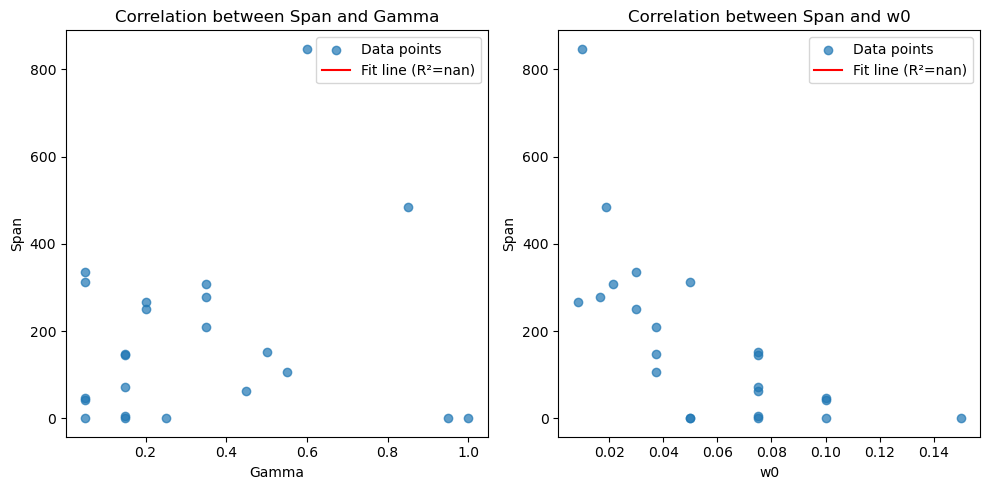

In [ ]:
from scipy.stats import linregress

# 提取 metrics_df 中的 Span 列
spans = metrics_df['Span']
firstcross = metrics_df['FirstCross']

# 提取 cluster_results 中的 gamma 和 w0
gammas = [results[i]['best_params']['gamma'] for i in metrics_df.index]
w0s = [results[i]['best_params']['w0'] for i in metrics_df.index]

# 计算 Span 和 gamma 的相关性并绘制散点图和回归直线
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(gammas, spans, alpha=0.7, label='Data points')
slope, intercept, r_value, p_value, std_err = linregress(gammas, spans)
plt.plot(gammas, [slope * x + intercept for x in gammas], color='red', label=f'Fit line (R²={r_value**2:.2f})')
plt.xlabel('Gamma')
plt.ylabel('Span')
plt.title('Correlation between Span and Gamma')
plt.legend()

# 计算 Span 和 w0 的相关性并绘制散点图和回归直线
plt.subplot(1, 2, 2)
plt.scatter(w0s, spans, alpha=0.7, label='Data points')
slope, intercept, r_value, p_value, std_err = linregress(w0s, spans)
plt.plot(w0s, [slope * x + intercept for x in w0s], color='red', label=f'Fit line (R²={r_value**2:.2f})')
plt.xlabel('w0')
plt.ylabel('Span')
plt.title('Correlation between Span and w0')
plt.legend()

plt.tight_layout()
plt.show()

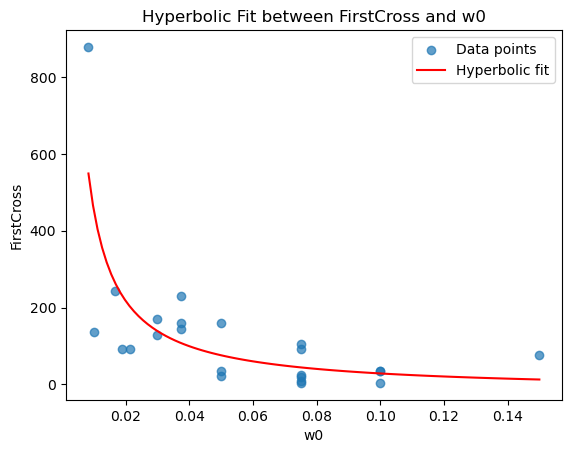

Hyperbolic fit parameters: a = 4.728450453485582, b = -18.638123284355952


In [ ]:
from scipy.optimize import curve_fit
import numpy as np

# 定义双曲线函数
def hyperbola(x, a, b):
    return a / x + b

# 去掉 w0=0.15 的极端值并过滤掉 NaN 值
filtered_data = [(w0, fc) for w0, fc in zip(w0s, firstcross) if w0 != 0.16 and not np.isnan(fc)]
filtered_w0s, filtered_spans = zip(*filtered_data)

# 拟合双曲线
params, _ = curve_fit(hyperbola, filtered_w0s, filtered_spans, maxfev=10000)
a, b = params

# 绘制拟合曲线
w0_range = np.linspace(min(filtered_w0s), max(filtered_w0s), 100)
fitted_spans = hyperbola(w0_range, a, b)

plt.scatter(filtered_w0s, filtered_spans, alpha=0.7, label='Data points')
plt.plot(w0_range, fitted_spans, color='red', label='Hyperbolic fit')
plt.xlabel('w0')
plt.ylabel('FirstCross')
plt.title('Hyperbolic Fit between FirstCross and w0')
plt.legend()
plt.show()

# 输出拟合的双曲线参数
print(f"Hyperbolic fit parameters: a = {a}, b = {b}")

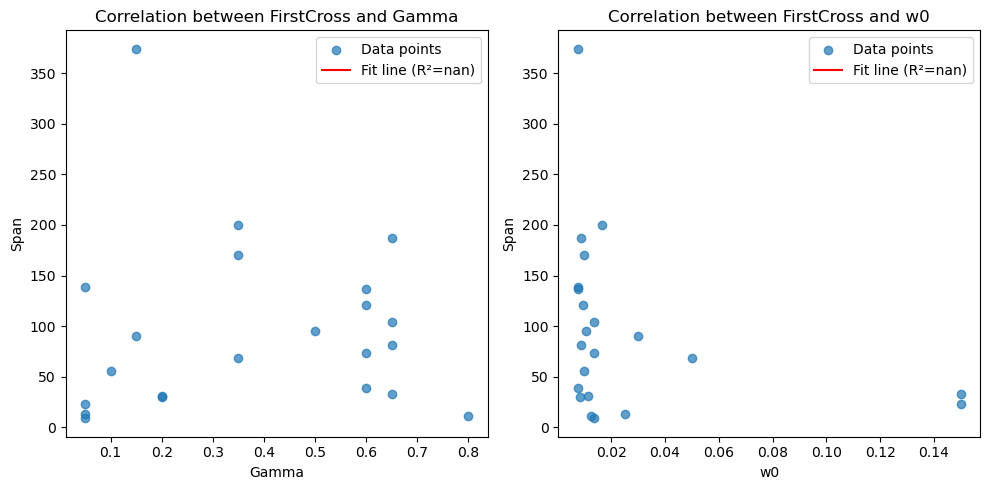

In [ ]:
from scipy.stats import linregress

# 提取 metrics_df 中的 FirstCross 列
firstcross = metrics_df['FirstCross']

# 提取 cluster_results 中的 gamma 和 w0
gammas = [cluster_results[i]['best_params']['gamma'] for i in metrics_df.index]
w0s = [cluster_results[i]['best_params']['w0'] for i in metrics_df.index]

# 计算 Span 和 gamma 的相关性并绘制散点图和回归直线
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(gammas, firstcross, alpha=0.7, label='Data points')
slope, intercept, r_value, p_value, std_err = linregress(gammas, firstcross)
plt.plot(gammas, [slope * x + intercept for x in gammas], color='red', label=f'Fit line (R²={r_value**2:.2f})')
plt.xlabel('Gamma')
plt.ylabel('Span')
plt.title('Correlation between FirstCross and Gamma')
plt.legend()

# 计算 Span 和 w0 的相关性并绘制散点图和回归直线
plt.subplot(1, 2, 2)
plt.scatter(w0s, firstcross, alpha=0.7, label='Data points')
slope, intercept, r_value, p_value, std_err = linregress(w0s, firstcross)
plt.plot(w0s, [slope * x + intercept for x in w0s], color='red', label=f'Fit line (R²={r_value**2:.2f})')
plt.xlabel('w0')
plt.ylabel('Span')
plt.title('Correlation between FirstCross and w0')
plt.legend()

plt.tight_layout()
plt.show()